Importing Libraries

In [ ]:
import random
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import confusion_matrix, classification_report

import onnxruntime as ort
import random
from PIL import Image

#Device Setup (Using cpu as gpu is unavailable)
torch_device = torch.device("cpu")

data_root_directory = Path("C:/Users/suyas/plant-disease-recognizer/ClassifiedImages")

#Fixing the training hyperparameters
input_image_dims: int = 128          # keep 128×128 to match your mobile pipeline
training_size: int = 64
validation_size: int = 64
epochs: int = 15          # single-phase, simple training

learning_rate: float = 1e-3             # simple, stable learning rate
weight_decay: float = 1e-4          # mild regularization
label_smoothing: float = 0.05          # reduces overconfidence a bit without complexity

best_model_path = Path("MobileNetV3_main_model.pth")


Exploratory Data Analysis

Discovered classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']
Number of classes: 15
Training images: 14487
Validation images: 3061


C:\Users\suyas\AppData\Local\Temp\ipykernel_61176\1202818791.py:34: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(); plt.show()


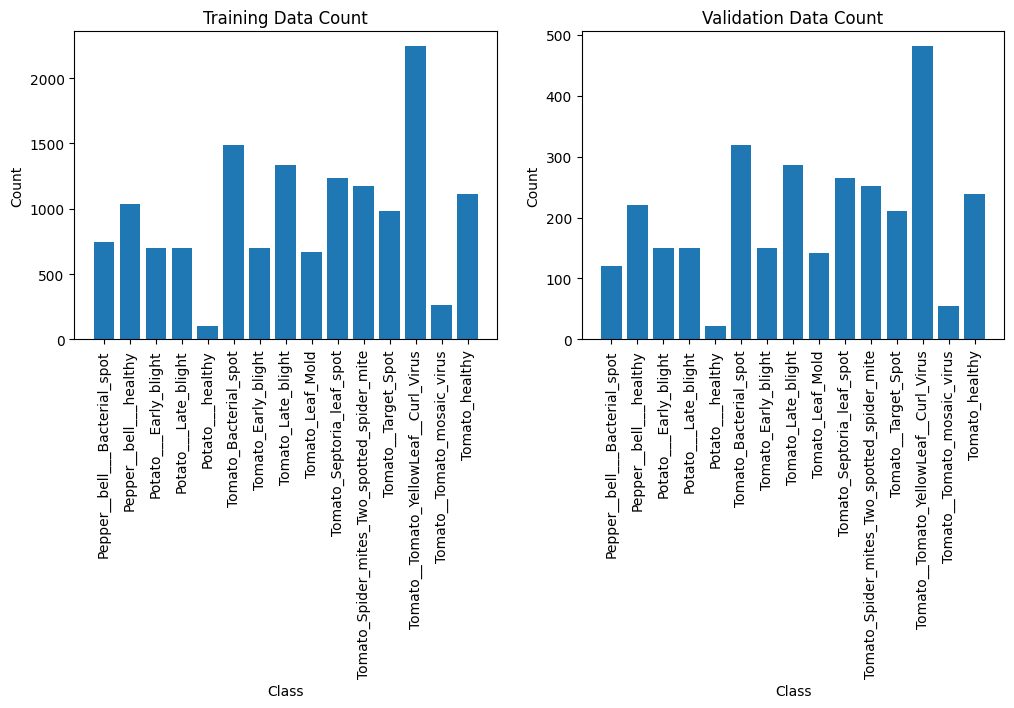

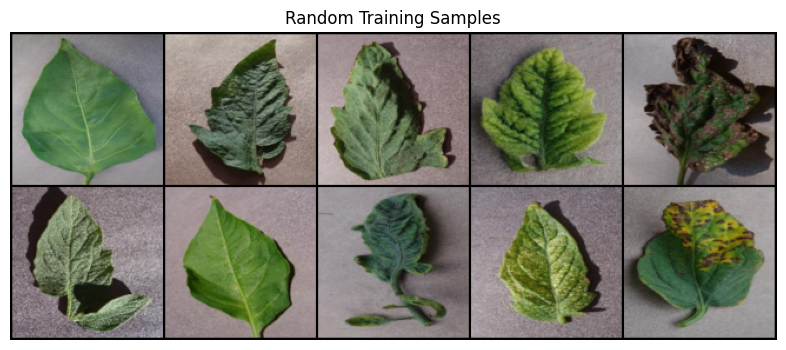

In [ ]:
eda_transform_no_normalize = transforms.Compose([
    transforms.Resize((input_image_dims, input_image_dims)),
    transforms.ToTensor(),  # no normalization for natural-looking previews
])

train_dataset = datasets.ImageFolder(data_root_directory / "train", transform=eda_transform_no_normalize)
val_dataset   = datasets.ImageFolder(data_root_directory / "validation",   transform=eda_transform_no_normalize)
testing_dataset = datasets.ImageFolder(data_root_directory / "test",   transform=eda_transform_no_normalize)

class_names_list = train_dataset.classes
number_of_classes = len(class_names_list)

print("Discovered classes:", class_names_list)
print("Number of classes:", number_of_classes)
print("Training images:", len(train_dataset))
print("Validation images:", len(val_dataset))

# Class counts
train_labels = [label for _, label in train_dataset.samples]
val_labels   = [label for _, label in val_dataset.samples]
train_class_counts = np.bincount(train_labels, minlength=number_of_classes)
val_class_counts   = np.bincount(val_labels, minlength=number_of_classes)

# Plot counts
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.bar(np.arange(number_of_classes), train_class_counts)
plt.title("Training Data Count"); plt.xlabel("Class"); plt.ylabel("Count")
plt.xticks(np.arange(number_of_classes), class_names_list, rotation=90)

plt.subplot(1,2,2)
plt.bar(np.arange(number_of_classes), val_class_counts)
plt.title("Validation Data Count"); plt.xlabel("Class"); plt.ylabel("Count")
plt.xticks(np.arange(number_of_classes), class_names_list, rotation=90)
plt.tight_layout(); plt.show()

# Show a small grid of random training images
def show_random_grid(dataset, title_text="Random Samples", rows=2, cols=5):
    import torchvision.utils as vutils
    idxs = np.random.choice(len(dataset), rows*cols, replace=False)
    images = [dataset[i][0] for i in idxs]
    grid = vutils.make_grid(images, nrow=cols, padding=2)
    plt.figure(figsize=(cols*2, rows*2))
    plt.imshow(np.transpose(grid.numpy(), (1,2,0))); plt.axis("off"); plt.title(title_text); plt.show()

show_random_grid(train_dataset, "Random Training Samples")


Data Augmentation

In [11]:
image_transforms_dictionary = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(input_image_dims, scale=(0.75, 1.0), ratio=(0.9, 1.1)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3),
    ]),
    "val": transforms.Compose([
        transforms.Resize((input_image_dims, input_image_dims)),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3),
    ]),
}

Loading the Data

In [25]:
train_dataset = datasets.ImageFolder(data_root_directory / "train", transform=image_transforms_dictionary["train"])
val_dataset   = datasets.ImageFolder(data_root_directory / "validation",   transform=image_transforms_dictionary["val"])
testing_dataset = datasets.ImageFolder(data_root_directory / "test",   transform=image_transforms_dictionary["val"])

# Simple loaders: shuffle only the training set, keep validation deterministic
training_dataloader = DataLoader(train_dataset, batch_size=training_size, shuffle=True,  num_workers=4, pin_memory=True)
validation_dataloader = DataLoader(val_dataset, batch_size=validation_size, shuffle=False, num_workers=4, pin_memory=True)
testing_dataloader = DataLoader(testing_dataset, batch_size=validation_size, shuffle=False, num_workers=4, pin_memory=True)

print("Batches per epoch — train:", len(training_dataloader), " | val:", len(validation_dataloader))

Batches per epoch — train: 227  | val: 48


Loading the Pre-Trained Model MobileNetv3-Small

In [14]:
pretrained_model = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.DEFAULT)
in_features_classifier = pretrained_model.classifier[-1].in_features
pretrained_model.classifier[-1] = nn.Linear(in_features_classifier, number_of_classes)
pretrained_model = pretrained_model.to(torch_device)

print(pretrained_model.classifier)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to C:\Users\suyas/.cache\torch\hub\checkpoints\mobilenet_v3_small-047dcff4.pth


100.0%


Sequential(
  (0): Linear(in_features=576, out_features=1024, bias=True)
  (1): Hardswish()
  (2): Dropout(p=0.2, inplace=True)
  (3): Linear(in_features=1024, out_features=15, bias=True)
)


CrossEntropy Loss Function and Adam Optimizer

In [15]:
classification_loss_function = nn.CrossEntropyLoss(label_smoothing=label_smoothing)

adamw_optimizer = torch.optim.AdamW(
    pretrained_model.parameters(),
    lr=learning_rate,
    weight_decay=weight_decay
)

print("Optimizer:", adamw_optimizer)

Optimizer: AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: True
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0.0001
)


Training the Model

In [17]:
best_validation_accuracy: float = 0.0
training_history = {"epoch": [], "train_loss": [], "val_loss": [], "val_acc": []}

for epoch_index in range(1, epochs + 1):
    # Training throughput
    pretrained_model.train()
    running_training_loss_sum: float = 0.0
    running_training_sample_count: int = 0

    for batch_input_images, batch_target_labels in training_dataloader:
        batch_input_images = batch_input_images.to(torch_device, non_blocking=True)
        batch_target_labels = batch_target_labels.to(torch_device, non_blocking=True)

        adamw_optimizer.zero_grad(set_to_none=True)
        prediction_logits = pretrained_model(batch_input_images)
        batch_loss_value = classification_loss_function(prediction_logits, batch_target_labels)
        batch_loss_value.backward()
        adamw_optimizer.step()

        running_training_loss_sum += batch_loss_value.item() * batch_input_images.size(0)
        running_training_sample_count += batch_input_images.size(0)

    epoch_training_loss = running_training_loss_sum / max(running_training_sample_count, 1)

    # Validation throughput
    pretrained_model.eval()
    running_validation_loss_sum: float = 0.0
    running_validation_correct_predictions: int = 0
    running_validation_sample_count: int = 0

    with torch.no_grad():
        for batch_input_images, batch_target_labels in validation_dataloader:
            batch_input_images = batch_input_images.to(torch_device, non_blocking=True)
            batch_target_labels = batch_target_labels.to(torch_device, non_blocking=True)

            prediction_logits = pretrained_model(batch_input_images)
            batch_loss_value = classification_loss_function(prediction_logits, batch_target_labels)

            running_validation_loss_sum += batch_loss_value.item() * batch_input_images.size(0)
            predicted_classes = prediction_logits.argmax(dim=1)
            running_validation_correct_predictions += (predicted_classes == batch_target_labels).sum().item()
            running_validation_sample_count += batch_input_images.size(0)

    epoch_validation_loss = running_validation_loss_sum / max(running_validation_sample_count, 1)
    epoch_validation_accuracy = running_validation_correct_predictions / max(running_validation_sample_count, 1)

    print(f"Epoch {epoch_index:02d} ; Train Loss: {epoch_training_loss:.5f} ; "
          f"Validation Loss: {epoch_validation_loss:.5f} ; Validation Acc: {epoch_validation_accuracy:.4f}")

    training_history["epoch"].append(epoch_index)
    training_history["train_loss"].append(epoch_training_loss)
    training_history["val_loss"].append(epoch_validation_loss)
    training_history["val_acc"].append(epoch_validation_accuracy)

    # Save best model's state
    if epoch_validation_accuracy > best_validation_accuracy:
        best_validation_accuracy = epoch_validation_accuracy
        torch.save(pretrained_model.state_dict(), best_model_path)

print("Best Validation Accuracy:", best_validation_accuracy)

c:\Users\suyas\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 01 ; Train Loss: 0.41188 ; Validation Loss: 0.44283 ; Validation Acc: 0.9611
Epoch 02 ; Train Loss: 0.38572 ; Validation Loss: 0.41077 ; Validation Acc: 0.9739
Epoch 03 ; Train Loss: 0.36654 ; Validation Loss: 0.46619 ; Validation Acc: 0.9481
Epoch 04 ; Train Loss: 0.35943 ; Validation Loss: 0.38673 ; Validation Acc: 0.9771
Epoch 05 ; Train Loss: 0.34899 ; Validation Loss: 0.35969 ; Validation Acc: 0.9873
Epoch 06 ; Train Loss: 0.35299 ; Validation Loss: 0.58725 ; Validation Acc: 0.9013
Epoch 07 ; Train Loss: 0.35510 ; Validation Loss: 0.37790 ; Validation Acc: 0.9814
Epoch 08 ; Train Loss: 0.34314 ; Validation Loss: 0.45091 ; Validation Acc: 0.9543
Epoch 09 ; Train Loss: 0.34171 ; Validation Loss: 0.42511 ; Validation Acc: 0.9628
Epoch 10 ; Train Loss: 0.34037 ; Validation Loss: 0.35328 ; Validation Acc: 0.9876
Epoch 11 ; Train Loss: 0.34331 ; Validation Loss: 0.45758 ; Validation Acc: 0.9500
Epoch 12 ; Train Loss: 0.34915 ; Validation Loss: 0.53536 ; Validation Acc: 0.9245
Epoc

Validation Data Evaluation

c:\Users\suyas\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation Accuracy (overall): 0.9876
  Class 'Pepper__bell___Bacterial_spot': accuracy=1.0000 (correct=121, total=121)
  Class 'Pepper__bell___healthy': accuracy=1.0000 (correct=221, total=221)
  Class 'Potato___Early_blight': accuracy=1.0000 (correct=150, total=150)
  Class 'Potato___Late_blight': accuracy=1.0000 (correct=150, total=150)
  Class 'Potato___healthy': accuracy=1.0000 (correct=22, total=22)
  Class 'Tomato_Bacterial_spot': accuracy=0.9969 (correct=318, total=319)
  Class 'Tomato_Early_blight': accuracy=0.9400 (correct=141, total=150)
  Class 'Tomato_Late_blight': accuracy=0.9685 (correct=277, total=286)
  Class 'Tomato_Leaf_Mold': accuracy=0.9930 (correct=141, total=142)
  Class 'Tomato_Septoria_leaf_spot': accuracy=0.9849 (correct=261, total=265)
  Class 'Tomato_Spider_mites_Two_spotted_spider_mite': accuracy=0.9801 (correct=246, total=251)
  Class 'Tomato__Target_Spot': accuracy=0.9857 (correct=207, total=210)
  Class 'Tomato__Tomato_YellowLeaf__Curl_Virus': accuracy=0

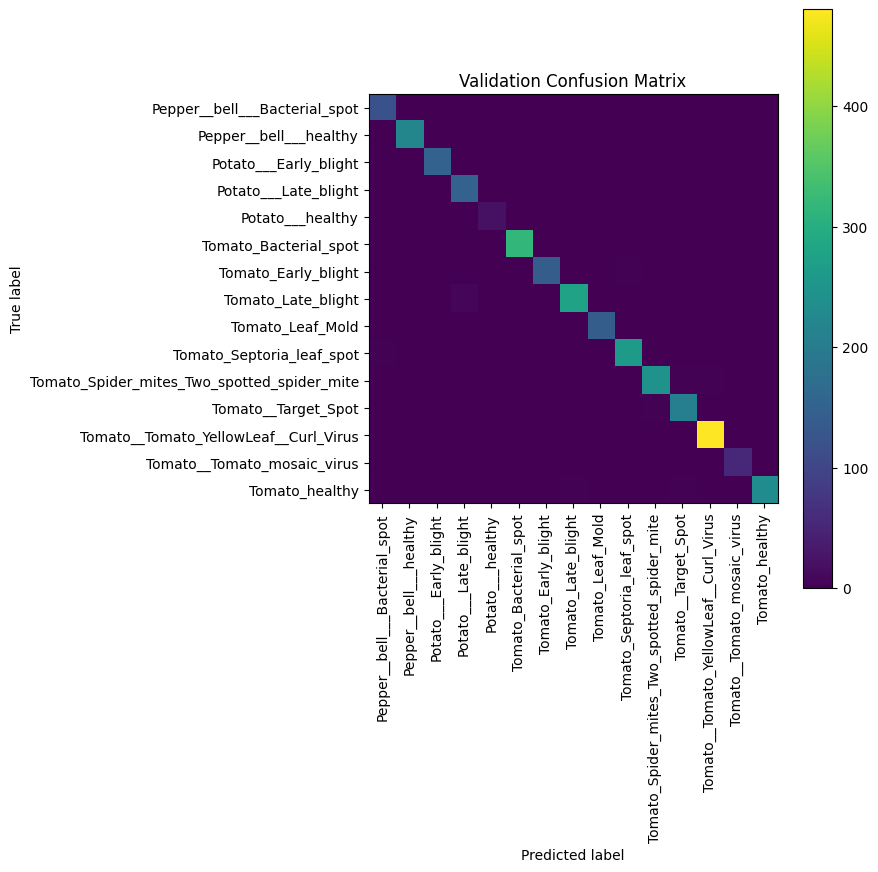

                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot     0.9603    1.0000    0.9798       121
                     Pepper__bell___healthy     1.0000    1.0000    1.0000       221
                      Potato___Early_blight     0.9934    1.0000    0.9967       150
                       Potato___Late_blight     0.9494    1.0000    0.9740       150
                           Potato___healthy     1.0000    1.0000    1.0000        22
                      Tomato_Bacterial_spot     0.9969    0.9969    0.9969       319
                        Tomato_Early_blight     1.0000    0.9400    0.9691       150
                         Tomato_Late_blight     0.9788    0.9685    0.9736       286
                           Tomato_Leaf_Mold     1.0000    0.9930    0.9965       142
                  Tomato_Septoria_leaf_spot     0.9849    0.9849    0.9849       265
Tomato_Spider_mites_Two_spotted_spider_mite     0.9801    0.9801

In [18]:
# Reload best weights
pretrained_model.load_state_dict(torch.load(best_model_path, map_location=torch_device))
pretrained_model.eval()

all_true_labels = []
all_predicted_labels = []

# Per-class accounting
perclass_correct = np.zeros(number_of_classes, dtype=np.int64)
perclass_total = np.zeros(number_of_classes, dtype=np.int64)

with torch.no_grad():
    for batch_input_images, batch_target_labels in validation_dataloader:
        batch_input_images = batch_input_images.to(torch_device, non_blocking=True)
        batch_target_labels = batch_target_labels.to(torch_device, non_blocking=True)

        prediction_logits = pretrained_model(batch_input_images)
        predicted_classes = prediction_logits.argmax(dim=1)

        all_true_labels.extend(batch_target_labels.cpu().numpy().tolist())
        all_predicted_labels.extend(predicted_classes.cpu().numpy().tolist())

        for gt, pr in zip(batch_target_labels.cpu().numpy(), predicted_classes.cpu().numpy()):
            perclass_total[gt] += 1
            if gt == pr:
                perclass_correct[gt] += 1

overall_validation_accuracy = (np.array(all_true_labels) == np.array(all_predicted_labels)).mean()
perclass_accuracy_values = perclass_correct / np.maximum(perclass_total, 1)

print(f"Validation Accuracy (overall): {overall_validation_accuracy:.4f}")
for class_index, class_name in enumerate(class_names_list):
    print(f"  Class '{class_name}': accuracy={perclass_accuracy_values[class_index]:.4f} "
          f"(correct={perclass_correct[class_index]}, total={perclass_total[class_index]})")

# Confusion matrix
conf_mat = confusion_matrix(all_true_labels, all_predicted_labels, labels=list(range(number_of_classes)))
plt.figure(figsize=(max(8, number_of_classes*0.6), max(6, number_of_classes*0.6)))
plt.imshow(conf_mat, interpolation='nearest')
plt.title("Validation Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(number_of_classes)
plt.xticks(tick_marks, class_names_list, rotation=90)
plt.yticks(tick_marks, class_names_list)
plt.xlabel("Predicted label"); plt.ylabel("True label")
plt.tight_layout(); plt.show()

# Classification report
report_text = classification_report(
    all_true_labels, all_predicted_labels,
    target_names=class_names_list, digits=4
)
print(report_text)

ONNX Conversion for Export

In [21]:
pretrained_model.load_state_dict(torch.load(best_model_path, map_location=torch_device))
pretrained_model.eval()

dummy_input_tensor = torch.randn(1, 3, input_image_dims, input_image_dims, device=torch_device)

onnx_export_path = Path("Plant_disease_MobileNetV3.onnx")
torch.onnx.export(
    pretrained_model,
    dummy_input_tensor,
    onnx_export_path.as_posix(),
    input_names=["input"],
    output_names=["logits"],
    opset_version=12,
    dynamic_axes=None
)

print("Exported ONNX model to:", onnx_export_path.resolve())

Exported ONNX model to: C:\Users\suyas\plant-disease-recognizer\Plant_disease_MobileNetV3.onnx


Testing Unseen Data on ONNX Model

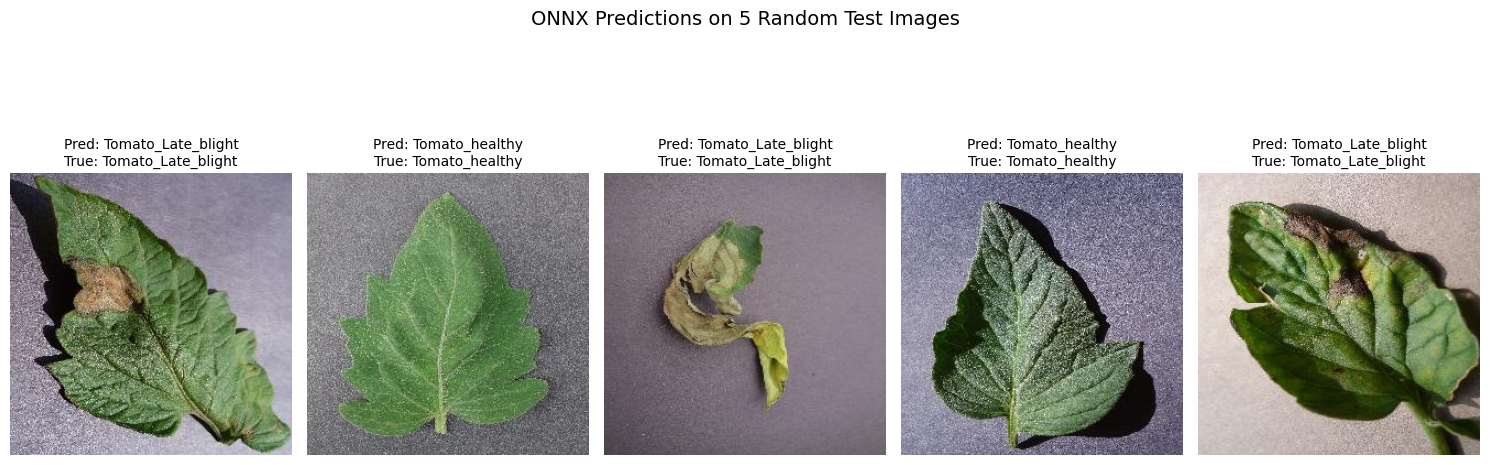

In [ ]:
onnx_session = ort.InferenceSession(onnx_export_path.as_posix(), providers=["CPUExecutionProvider"])
onnx_input_name = onnx_session.get_inputs()[0].name

preprocess_for_onnx = transforms.Compose([
    transforms.Resize((input_image_dims, input_image_dims)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

# Choose 5 random test samples by index
random_test_indices = random.sample(range(len(testing_dataset)), k=min(5, len(testing_dataset)))

plt.figure(figsize=(15, 6))
for subplot_position, dataset_index in enumerate(random_test_indices, start=1):
    image_path, true_label_index = testing_dataset.samples[dataset_index]
    pil_image = Image.open(image_path).convert("RGB")

    # Build input for ONNX
    input_tensor = preprocess_for_onnx(pil_image).unsqueeze(0)  # [1,3,H,W]
    input_numpy = input_tensor.numpy()

    # ONNX inference
    ort_outputs = onnx_session.run(None, {onnx_input_name: input_numpy})
    logits = ort_outputs[0]                     # [1, num_classes]
    predicted_index = int(np.argmax(logits, axis=1)[0])
    predicted_label = class_names_list[predicted_index]
    true_label = class_names_list[true_label_index]

    # Display
    plt.subplot(1, 5, subplot_position)
    plt.imshow(pil_image)
    plt.axis("off")
    plt.title(f"Pred: {predicted_label}\nTrue: {true_label}", fontsize=10)

plt.suptitle("ONNX Model Prediction on 5 Test Images", fontsize=14)
plt.tight_layout()
plt.show()